## Bag of Visual Words

In [1]:
import numpy as np
import cv2 as cv
from os import listdir
from os.path import isfile, join
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt  

In [2]:
train_address = "../dataset/SUN_data/train/"
test_address = "../dataset/SUN_data/test/"

def load_images(address):
    output = {}
    sub_folders = [f for f in listdir(address) if not isfile(join(address, f))]
    for sub_folder in sub_folders:
        path = address+sub_folder
        images = [f for f in listdir(path) if isfile(join(path, f))]
        category = []
        for image in images :
            path = address+sub_folder+'/'+image
            img = cv.imread(path,0)
            if img is not None :
                img = cv.resize(img,(150,150))
                category.append(img)
        output[sub_folder] = category
    return output

train_images = load_images(train_address)
test_images = load_images(test_address)

In [3]:
def sift_feature_des(images):
    sift = cv.xfeatures2d.SIFT_create()
    sift_vectors = {}
    descriptor_list = []
    for key,image in images.items():
        feature_des = []
        for img in image:
            kp, des = sift.detectAndCompute(img,None)
            descriptor_list.extend(des)
            feature_des.append(des)
        sift_vectors[key] = feature_des
    return descriptor_list, sift_vectors

train_descriptor_list, train_bovw_features = sift_feature_des(train_images) 
test_descriptor_list, test_bovw_features = sift_feature_des(test_images)

In [4]:
def kmeans(k, descriptor_list):
    visual_words = KMeans(n_clusters = k, n_init=10).fit(descriptor_list).cluster_centers_ 
    return visual_words

visual_words = kmeans(150, train_descriptor_list) 

In [5]:
def image_class(bovw, visual_words):
    dict_feature = {}
    for key,value in bovw.items():
        category = []
        for img in value:
            histogram = np.zeros(len(visual_words))
            for each_feature in img:
                min_dist = np.inf
                i = 0
                for center in visual_words:
                    dist = distance.euclidean(each_feature, center)
                    if dist < min_dist :
                        ind = i
                        min_dist = dist
                    i+=1
                histogram[ind] += 1
            category.append(histogram)
        dict_feature[key] = category
    return dict_feature
    
# Creates histograms for train data    
bovw_train = image_class(train_bovw_features, visual_words) 
# Creates histograms for test data
bovw_test = image_class(test_bovw_features, visual_words) 

In [6]:
def normalize_bovw(normalize, bovw):
    images = []
    labels = []
    for key, val in bovw.items():    
        for img in val:
            if(normalize):
                images.append(img/np.sum(img))
            else :
                images.append(img)
            labels.append(key)
    return images, labels

In [7]:
def plot_images(image, actual, predicted):
    plt.figure(figsize=(4,3))
    plt.imshow(image,cmap='gray')
    print("Actual class = ",actual)
    print("Predicted class = ",predicted)
    plt.show()

In [8]:
def svm_classify(bovw_train, bovw_test, images, reg, normalize, conf, show):
    X_train, y_train = normalize_bovw(normalize, bovw_train)
    X_test, y_test = normalize_bovw(normalize, bovw_test)
    
    svm_classifier = SVC(kernel = 'linear', C = reg).fit(X_train, y_train)
    svm_prediction = svm_classifier.predict(X_test)
    accuracy = svm_classifier.score(X_test,y_test)
    cm = confusion_matrix(y_test,svm_prediction)

    if conf:
        plt.figure(figsize=(50,50))
        plot_confusion_matrix(svm_classifier, X_test, y_test)
        plt.show()
    
    true_positive = 0
    false_negative = 0
    class_length = len(y_test)/8
    if show:
        for index, label in enumerate(y_test):
            
            if(index%class_length ==0):
                true_positive = 0
                false_negative = 0
                
            image = images[label][int(index%class_length)]
            if(true_positive<1 and svm_prediction[index]==label):
                plot_images(image, label, label)
                true_positive+=1
            
            if(false_negative<1 and svm_prediction[index]!=label):
                plot_images(image, label, svm_prediction[index])
                false_negative+=1
            
    return accuracy, cm

In [9]:
acc_n_list = []
acc_nn_list = []
for i in range(1,25):
    acc_n, cm_n = svm_classify(bovw_train, bovw_test, test_images, i, 1, 0, 0) 
    acc_n_list.append(acc_n)
    acc_nn, cm_nn = svm_classify(bovw_train, bovw_test, test_images, i, 0, 0, 0) 
    acc_nn_list.append(acc_nn)

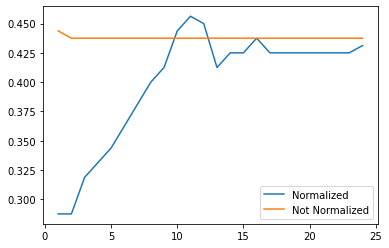

In [10]:
plt.plot(range(1,25),acc_n_list,label="Normalized")
plt.plot(range(1,25),acc_nn_list,label="Not Normalized")
plt.legend()
plt.show()

In [11]:
# Call the svm classifier on Train images without Normalization
acc, cm = svm_classify(bovw_train, bovw_train, train_images, 21, 0, 0, 0)
print("Training Accuracy without Normalization = ",100*acc)

Training Accuracy without Normalization =  100.0


<Figure size 3600x3600 with 0 Axes>

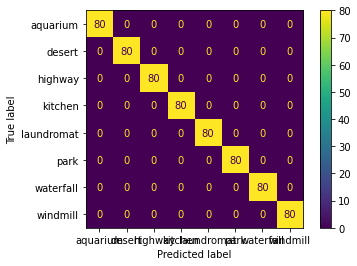

Confusion Matrix for train without Normalization = 
[[80  0  0  0  0  0  0  0]
 [ 0 80  0  0  0  0  0  0]
 [ 0  0 80  0  0  0  0  0]
 [ 0  0  0 80  0  0  0  0]
 [ 0  0  0  0 80  0  0  0]
 [ 0  0  0  0  0 80  0  0]
 [ 0  0  0  0  0  0 80  0]
 [ 0  0  0  0  0  0  0 80]]


In [12]:
acc, cm = svm_classify(bovw_train, bovw_train, train_images, 21, 0, 1, 0)
print("Confusion Matrix for train without Normalization = ")
print(cm)

In [13]:
# Call the svm classifier on Train images with Normalization
acc, cm = svm_classify(bovw_train, bovw_train, train_images, 21, 1, 0, 0)
print("Training Accuracy with Normalization = ",100*acc)

Training Accuracy with Normalization =  66.40625


<Figure size 3600x3600 with 0 Axes>

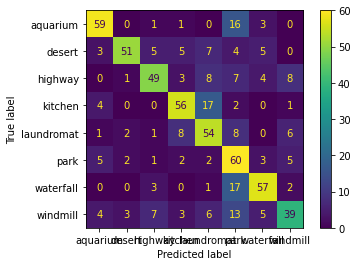

Confusion Matrix for train with Normalization = 
[[59  0  1  1  0 16  3  0]
 [ 3 51  5  5  7  4  5  0]
 [ 0  1 49  3  8  7  4  8]
 [ 4  0  0 56 17  2  0  1]
 [ 1  2  1  8 54  8  0  6]
 [ 5  2  1  2  2 60  3  5]
 [ 0  0  3  0  1 17 57  2]
 [ 4  3  7  3  6 13  5 39]]


In [14]:
acc, cm = svm_classify(bovw_train, bovw_train, train_images, 21, 1, 1, 0)
print("Confusion Matrix for train with Normalization = ")
print(cm)

In [15]:
# Call the svm classifier on Test images without Normalizatin
acc, cm = svm_classify(bovw_train, bovw_test, test_images, 21, 0, 0, 0)
print("Testing Accuracy without Normalization = ",100*acc)

Testing Accuracy without Normalization =  43.75


<Figure size 3600x3600 with 0 Axes>

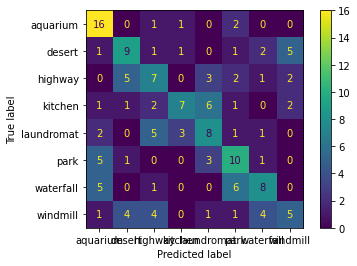

Confusion Matrix for train without Normalization = 
[[16  0  1  1  0  2  0  0]
 [ 1  9  1  1  0  1  2  5]
 [ 0  5  7  0  3  2  1  2]
 [ 1  1  2  7  6  1  0  2]
 [ 2  0  5  3  8  1  1  0]
 [ 5  1  0  0  3 10  1  0]
 [ 5  0  1  0  0  6  8  0]
 [ 1  4  4  0  1  1  4  5]]


In [16]:
acc, cm = svm_classify(bovw_train, bovw_test, test_images, 21, 0, 1, 0)
print("Confusion Matrix for test without Normalization = ")
print(cm)

In [17]:
# Call the svm classifier on Test images with Normalizatin
acc, cm = svm_classify(bovw_train, bovw_test, test_images, 21, 1, 0, 0)
print("Testing Accuracy with Normalization = ",100*acc)

Testing Accuracy with Normalization =  42.5


<Figure size 3600x3600 with 0 Axes>

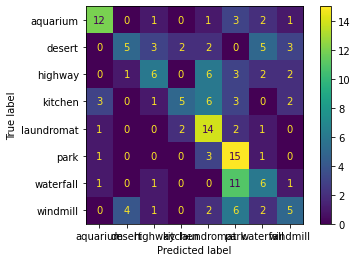

Confusion Matrix for train with Normalization = 
[[12  0  1  0  1  3  2  1]
 [ 0  5  3  2  2  0  5  3]
 [ 0  1  6  0  6  3  2  2]
 [ 3  0  1  5  6  3  0  2]
 [ 1  0  0  2 14  2  1  0]
 [ 1  0  0  0  3 15  1  0]
 [ 1  0  1  0  0 11  6  1]
 [ 0  4  1  0  2  6  2  5]]


In [18]:
acc, cm = svm_classify(bovw_train, bovw_test, test_images, 21, 1, 1, 0)
print("Confusion Matrix for test with Normalization = ")
print(cm)

Actual class =  highway
Predicted class =  highway


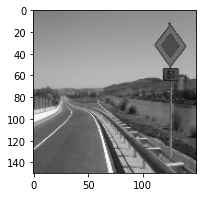

Actual class =  highway
Predicted class =  windmill


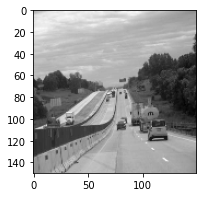

Actual class =  waterfall
Predicted class =  park


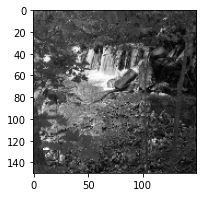

Actual class =  waterfall
Predicted class =  waterfall


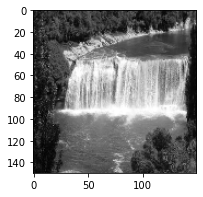

Actual class =  kitchen
Predicted class =  kitchen


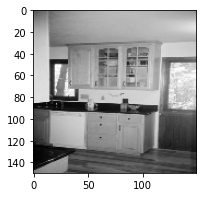

Actual class =  kitchen
Predicted class =  windmill


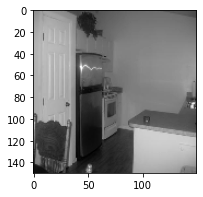

Actual class =  park
Predicted class =  waterfall


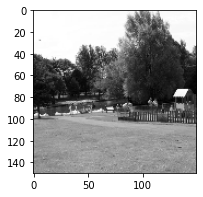

Actual class =  park
Predicted class =  park


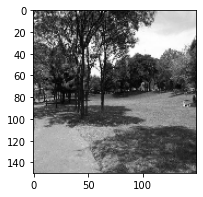

Actual class =  laundromat
Predicted class =  waterfall


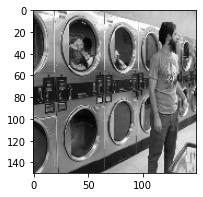

Actual class =  laundromat
Predicted class =  laundromat


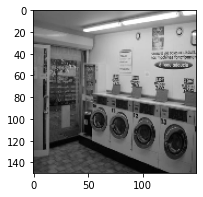

Actual class =  desert
Predicted class =  desert


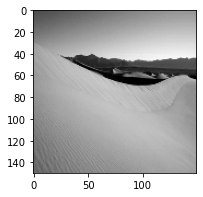

Actual class =  desert
Predicted class =  waterfall


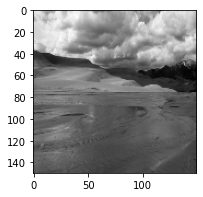

Actual class =  windmill
Predicted class =  desert


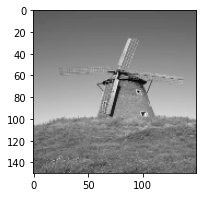

Actual class =  windmill
Predicted class =  windmill


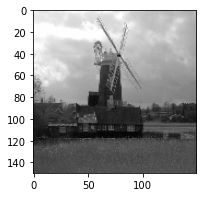

Actual class =  aquarium
Predicted class =  aquarium


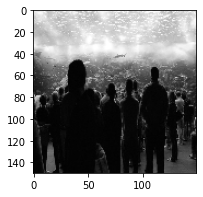

Actual class =  aquarium
Predicted class =  waterfall


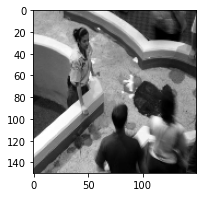

In [19]:
# Some sample images using classified normalized test set
acc, cm = svm_classify(bovw_train, bovw_test, test_images,21, 1, 0, 1)